# Linear Neural Network - Softmax Regression - MNIST

In this notebook, we formulate the Softmax Regression technique for multiclass classification as a Linear Neural Network (LNN) model. We use the MNIST handwritten digits dataset for our classification tasks.


We will apply **two types of regularization** in the LNN model:
- Weight regularization (L2 or L1)
- Early stopping

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt


from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report

import tensorflow as tf

## Multiclass Dataset


We use the MNIST (Modified National Institute of Standards and Technology) dataset, which is a set of 70,000 small images of digits handwritten by high school students and employees of the US Census Bureau. Each image is labeled with the digit it represents.


There are 70,000 images. Each image is **grayscale 28 x 28 pixels**, and each feature simply represents one pixel’s intensity, from 0 (white) to 255 (black).

Thus, each image has **784 features**. 

The task is to classify a given image of a handwritten digit into one of 10 classes representing integer values from 0 to 9, inclusively.


## Load the Dataset

In [2]:
# Load data 
mnist = fetch_openml('mnist_784', parser='auto', cache=False)

# Create feature matrix and target array; then typecast
X = mnist["data"].astype('float32')
y = mnist["target"].astype('int64')


print("\nNo. of Samples: ", X.shape)
print("No. of Labels: ", y.shape)


No. of Samples:  (70000, 784)
No. of Labels:  (70000,)


## Scale the Dataset

In [3]:
X /= 255.0

## Create Train, Validation, and Test Subsets

In [4]:
# Create training and test subsets from the full dataset
X_train_full, X_test, y_train_full, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# Create train and validation subsets from the training set
X_train, X_valid, y_train, y_valid = train_test_split(X_train_full, y_train_full, test_size=0.2, random_state=0)

print("\nShape of Training Samples: ", X_train.shape)
print("Shape of Training Labels: ", y_train.shape)

print("\nShape of Validation Samples: ", X_valid.shape)
print("Shape of Validation Labels: ", y_valid.shape)

print("\nShape of Testing Samples: ", X_test.shape)
print("Shape of Testing Labels: ", y_test.shape)


Shape of Training Samples:  (44800, 784)
Shape of Training Labels:  (44800,)

Shape of Validation Samples:  (11200, 784)
Shape of Validation Labels:  (11200,)

Shape of Testing Samples:  (14000, 784)
Shape of Testing Labels:  (14000,)


## Create an LNN Model

We use the Keras Dense layer to create an LNN model for Softmax Regression. In a Dense layer, each neuron is fully connected to all inputs/neurons of the previous layer.

To build the LNN model, we will use the Sequential class from tf.keras.models, a module in TensorFlow's Keras API that allows us to stack layers, such as Dense layers, in a linear sequence. This makes it easy to define models layer by layer.

The LNN model:
- Has 10 output neurons, corresponding to the MNIST 10-class classification problem.
- Uses the softmax activation function to convert the output into probabilities.


First, we need to specify the shape of the input using the Input layer, which instantiates a Keras tensor—a symbolic TensorFlow tensor.
- The "shape" parameter is a tuple of integers that defines the dimensionality of the input vectors. In this demo, the input is a 784-dimensional vector obtained by flattening the 28x28 matrices during data loading, so we use the tuple (784,). Note that the batch size is not included in this shape definition.


Dense layer:
- kernel_initializer: We initialize the weights (the kernel) to **zero**. This is acceptable for logistic/softmax regression. However, for nonlinear networks like Multi-layer Perceptrons (MLPs), we need to use initializers like Glorot or He, which assign small random values to the weights.
- activation: We use the softmax activation function.

### Implementing Weight-based Regularization
- Weight-based regularization can be implemented in Keras using the regularizers argument in layers. Regularization helps to prevent overfitting by penalizing large weights and adding a penalty term to the loss function.
- L2 Regularization adds a penalty proportional to the sum of the squared weights, discouraging large weight values. L1 Regularization adds a penalty proportional to the absolute values of the weights, encouraging sparsity by driving some weights to zero.
- We can apply L1 or L2 regularization (or a combination of both, called Elastic Net regularization) using the tf.keras.regularizers.L1 or tf.keras.regularizers.L2 functions.

      -- Parameters: l1/l2: The regularization factor, controlling the strength of the penalty. Larger values mean stronger regularization.

In [5]:
%%time

'''
Delete the TensorFlow graph before creating a new model, otherwise, memory overflow will occur.
'''
tf.keras.backend.clear_session()

'''
To reproduce the same result by the model in each iteration, we use fixed seeds for random number generation. 
np.random.seed(42) ensures that any random numbers generated using NumPy will be the same in each run.
tf.random.set_seed(42) ensures that any random numbers generated using TensorFlow 
(such as during weight initialization or stochastic processes in TensorFlow) will be the same in each run.
'''
np.random.seed(42)
tf.random.set_seed(42)


number_of_classes = 10
# Declare and initialize the weight-based regularizer variable
# To disable weight-based regularization, set this variable to None
regularizer = tf.keras.regularizers.L2(l2=0.0001)
#regularizer = tf.keras.regularizers.L2(l2=0.0001)


'''
Create a Sequential model composed of a single stack of layers connected sequentially. 
'''
model = tf.keras.models.Sequential(name="LNN_MNIST")
model.add(tf.keras.layers.Input(shape=[784,]))
model.add(tf.keras.layers.Dense(units=number_of_classes, 
                                kernel_initializer="zeros",
                                kernel_regularizer=regularizer,
                                activation="softmax"))


# Display a detailed summary of the model: layer names and types, output shape, and the number of parameters
model.summary() 

Model: "LNN_MNIST"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 10)                7850      
                                                                 
Total params: 7,850
Trainable params: 7,850
Non-trainable params: 0
_________________________________________________________________
CPU times: user 35.7 ms, sys: 10.1 ms, total: 45.8 ms
Wall time: 40.9 ms


## Compile & Train the LNN Model

A Keras model automatically employs the **backpropagation** algorithm to train an artificial neural network (ANN). However, we need to specify an optimization algorithm.

There are various advanced optimizers available, but for our LNN, we will use the **stochastic gradient descent (SGD)** optimizer, which requires setting an appropriate learning rate.

We will implement mini-batch SGD, so it's essential to specify both the batch size and the number of epochs.


### History Object
To monitor the performance of our model during training, we will utilize the tf.keras.callbacks.History object. This object automatically tracks key metrics, such as loss and accuracy, for each epoch across both training and validation datasets.

The History object is automatically applied when a model is trained using the fit() method in TensorFlow Keras. It records metrics, including:
- Loss for both training and validation data.
- Accuracy (or other metrics) for both training and validation data.

By analyzing this recorded history, we can assess the effectiveness of our training process and make necessary adjustments.


### Implementing Early Stopping

We can implement early stopping by using the **EarlyStopping callback** function. It will interrupt training when it measures no progress on the validation set for a number of epochs (defined by the patience argument), and it will optionally roll back to the best model. 

The following are the parameters of this callback:
- monitor: Quantity to be monitored.
- min_delta: Minimum change in the monitored quantity to qualify as an improvement, i.e., an absolute change of less than min_delta, will count as no improvement.
- patience: Number of epochs with no improvement after which training will be stopped.
- verbose: verbosity mode.
- mode: One of {"auto", "min", "max"}. In min mode, training will stop when the quantity monitored has stopped decreasing; in "max" mode it will stop when the quantity monitored has stopped increasing; in "auto" mode, the direction is automatically inferred from the name of the monitored quantity.
- baseline: Baseline value for the monitored quantity. Training will stop if the model doesn't show improvement over the baseline.
- restore_best_weights: Whether to restore model weights from the epoch with the best value of the monitored quantity. If False, the model weights obtained at the last step of training are used.


In [6]:
'''
Define the optimizer
An optimizer object implements an optimization algorithm used to minimize the loss function during model training.
Below, the stochastic gradient descent (SGD) optimizer is used.
'''
optimizer = tf.keras.optimizers.SGD(learning_rate=0.5)

'''
Compile the model

The model.compile() method is used to configure the model for training. 
It prepares the model for the training process by defining how the model will learn and be evaluated.
It specifies three key components:
- Optimizer: The algorithm used to update the weights of the model (e.g., SGD).
- Loss function: The function the model tries to minimize, 
  which measures how well the model's predictions match the true values (e.g., binary_crossentropy, mean_squared_error).
- Metrics: Additional evaluation criteria for the model's performance, such as accuracy, 
           which are not involved in training but are used for monitoring.

'''
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=optimizer,
              metrics=["accuracy"])

'''
Set the epochs and batch size
'''
no_of_epochs = 200
size_of_mini_batch = 64


'''
Declare and initialize the early stopping callback function
- It will monitor validation loss and stop training if there are no improvements for 10 consecutive epochs
- With restore_best_weights set to True, the model will revert to the weights from the epoch 
where the validation loss (or other monitored metric) was at its minimum.
- With min_delta set to 0, any improvement in the monitored metric (such as validation loss) will be considered as progress.
  -- If min_delta=0, the early stopping callback will consider even the smallest change (positive or negative) 
     in the monitored metric as an improvement.
  -- If min_delta is set to a positive value, say min_delta=0.01, the model will only consider 
     a change greater than 0.01 in the monitored metric as an improvement, ignoring smaller variations.
'''
early_stopping_cb = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                  min_delta=0, 
                                  patience=10, 
                                  verbose=1, 
                                  mode='auto',
                                  restore_best_weights=True)

'''
Train the model
The History object is applied when a model is trained using the fit() method.
It automatically tracks the performance of a model during training. 
It records key metrics such as loss and accuracy for each epoch, for both training and validation data.
'''
history = model.fit(X_train, # Input data
                    y_train, # target data
                    batch_size=size_of_mini_batch, # Number of samples per gradient update.
                    epochs=no_of_epochs, # Number of epochs to train the model.
                    validation_data=(X_valid, y_valid), 
                    callbacks=[early_stopping_cb], # Early stopping callback function
                    #validation_split=0.10, # Fraction of the training data to be used as validation data. Float between 0 and 1. 
                    verbose=1 # Verbosity mode. 0 = silent, 1 = progress bar, 2 = one line per epoch. 
                   )

Epoch 1/200
  1/700 [..............................] - ETA: 48s - loss: 2.3026 - accuracy: 0.0781

2024-09-21 11:15:24.333213: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


700/700 [==============================] - 0s 458us/step - loss: 0.3955 - accuracy: 0.8889 - val_loss: 0.3138 - val_accuracy: 0.9141
Epoch 2/200
700/700 [==============================] - 0s 379us/step - loss: 0.3201 - accuracy: 0.9130 - val_loss: 0.3217 - val_accuracy: 0.9104
Epoch 3/200
700/700 [==============================] - 0s 374us/step - loss: 0.3092 - accuracy: 0.9159 - val_loss: 0.3037 - val_accuracy: 0.9179
Epoch 4/200
700/700 [==============================] - 0s 390us/step - loss: 0.3032 - accuracy: 0.9187 - val_loss: 0.3064 - val_accuracy: 0.9179
Epoch 5/200
700/700 [==============================] - 0s 379us/step - loss: 0.3009 - accuracy: 0.9201 - val_loss: 0.3068 - val_accuracy: 0.9187
Epoch 6/200
700/700 [==============================] - 0s 383us/step - loss: 0.2976 - accuracy: 0.9217 - val_loss: 0.3065 - val_accuracy: 0.9190
Epoch 7/200
700/700 [==============================] - 0s 383us/step - loss: 0.2978 - accuracy: 0.9218 - val_loss: 0.3106 - val_accuracy: 0.91

## Learning Curve


A learning curve is a graphical representation that shows the relationship between a model’s performance (often measured by metrics like accuracy, loss, or error) and the amount of training data or iterations (epochs).

In the context of machine learning, the learning curve typically tracks two main aspects:

- Training Performance: The model's performance on the training data over time.
- Validation/Test Performance: The model's performance on unseen validation or test data over time.

Key Insights from a Learning Curve:
- Convergence: When both training and validation curves flatten, the model has likely converged.
- Overfitting: If the training performance is good but the validation performance is poor, the model is overfitting.
- Underfitting: If both the training and validation performance are poor, the model may be underfitting.




## A Function For Generating Learning Curves (Accuracy & Loss)

In [7]:
def plot_learning_curves(history, numOfEpochs, title):
    plt.figure(figsize=(18,6))

    plt.subplot(121)
    plt.plot(range(1,numOfEpochs+1),history.history['val_accuracy'],label='validation')
    plt.plot(range(1,numOfEpochs+1),history.history['accuracy'],label='training')
    plt.legend(loc=0)
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.xlim([1,numOfEpochs])
    plt.grid(True)
    plt.title("Model Accuracy: "+title)
    
    plt.subplot(122)
    plt.plot(range(1,numOfEpochs+1),history.history['val_loss'],label='validation')
    plt.plot(range(1,numOfEpochs+1),history.history['loss'],label='training')
    plt.legend(loc=0)
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.xlim([1,numOfEpochs])
    plt.grid(True)
    plt.title("Model Loss: "+title)
    
    plt.show() 

Epochs:  19


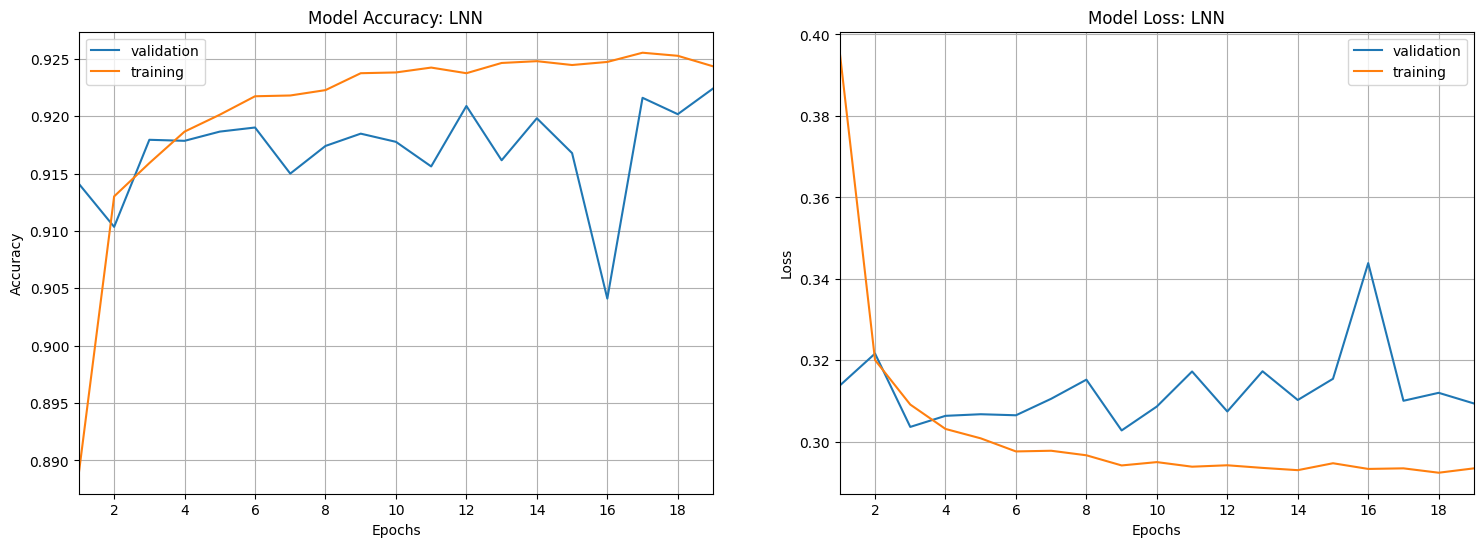

In [8]:
numOfEpochs = len(history.history['loss'])
print("Epochs: ", numOfEpochs)

plot_learning_curves(history, numOfEpochs, "LNN")

## Evaluate the LNN Model

In [10]:
print("Epochs: ", numOfEpochs)

# Display train and test performance metrics (accuracy and loss)
print("\nTrain Data: Loss & Accuracy: ", model.evaluate(X_train, y_train, verbose=0))
print("\nTest Data: Loss & Accuracy: ", model.evaluate(X_test, y_test, verbose=0))


'''
Compute the train accuracy
'''
# The model.predict() method returns 10 probabilities per class for each instance (Dimension Nx10)
y_train_predicted = model.predict(X_train)
y_train_predicted = np.argmax(y_train_predicted, axis=1) # get the label/index of the highest probability class

train_accuracy = np.mean(y_train_predicted == y_train)

'''
Compute the test accuracy
'''
# The model.predict() method returns 10 probabilities per class for each instance (Dimension Nx10)
y_test_predicted = model.predict(X_test)
y_test_predicted = np.argmax(y_test_predicted, axis=1) # get the label/index of the highest probability class
test_accuracy = np.mean(y_test_predicted == y_test)



print("\nTrain Accuracy: ", train_accuracy)
print("\nTest Accuracy: ", test_accuracy)

print("\nTest Confusion Matrix:")
print(confusion_matrix(y_test, y_test_predicted))

print("\nTest Classification Report:")
print(classification_report(y_test, y_test_predicted))

Epochs:  19

Train Data: Loss & Accuracy:  [0.2795220613479614, 0.9278794527053833]

Test Data: Loss & Accuracy:  [0.32350045442581177, 0.915142834186554]
438/438 [==============================] - 0s 181us/step

Train Accuracy:  0.9278794642857143

Test Accuracy:  0.9151428571428571

Test Confusion Matrix:
[[1338    0    5    3    2   16   15    3    5    0]
 [   0 1547    9    5    2    7    1    2    7    0]
 [   6   20 1297   24   25    6   11   15   34    5]
 [   3    7   49 1269    0   52    2   10   28   15]
 [   1    5   12    2 1275    3   14    9    2   27]
 [  10   10   11   43   15 1091   19    8   20    4]
 [  12    5   15    1   16   22 1309    2    5    0]
 [   4    9   24    6   11    6    1 1347    5   45]
 [   6   48   16   35   12   59   10    5 1165   12]
 [   5    8    9   20   65   18    1   53    8 1174]]

Test Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.96      0.97      1387
           1       0.9